In [1]:
import tensorflow
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Read Data

In [2]:
df = pd.read_csv('/tf/School/Neural Networks and Deep Learning/NNDL-Assignments/features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [3]:
df['label'].value_counts()

pop          100
blues        100
reggae       100
classical    100
disco        100
metal        100
rock         100
jazz         100
hiphop       100
country      100
Name: label, dtype: int64

Split and scale dataset

In [4]:
columns_to_drop = ['label','filename', 'length']

In [5]:
def prepare_dataset(df, columns_to_drop, test_size, random_state):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # devide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    #scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test

In [6]:
X_train, y_train, X_test, y_test = prepare_dataset(df, columns_to_drop, test_size=0.3, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(700, 57) (700,)
(300, 57) (300,)


# Question 1
### Create model

In [7]:
model = Sequential([
    Dense(16, activation='relu'),
    Dropout(rate=0.3),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

### Train Model

In [8]:
history = model.fit(X_train, y_train,
                   batch_size=1,
                   epochs=50,
                   verbose=0,
                   use_multiprocessing=True,
                   validation_data=(X_test, y_test))

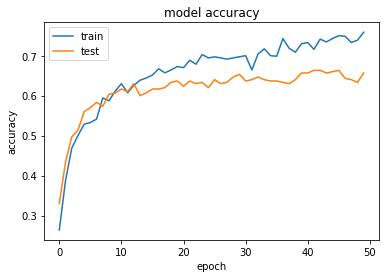

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

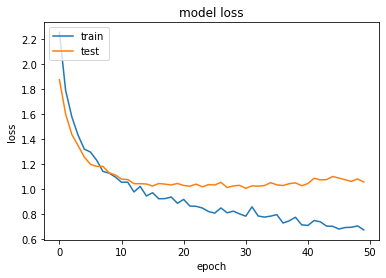

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### Training Result
---
As we can see from the data above, the accuracy for both the train and test data increases and stabilises at 75% and 65% respectively. The accuracy does not increase smoothly and tends to fluctuate a bit.

As for the loss, we can see that there is a point of diminishing returns after roughly 15 epochs where the training loss decreases but the validation loss increases.

---
# Question 2
### Timing Callback


In [11]:
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.times = []
    def on_train_batch_begin(self, batch, logs={}):
        self.starttime = time.time()
    def on_train_batch_end(self, batch, logs={}):
        self.times.append(time.time() - self.starttime)

In [12]:
batch_sizes = [1, 4, 8, 16, 32, 64]
        
def train(batch_size):
    model = Sequential([
        Dense(16, activation='relu'),
        Dropout(rate=0.3),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
    
    call_back = TimingCallback()
    splits = 3
    kf = KFold(n_splits=splits)
    
    entropies=[]
    accuracies=[]
    avg_times=[] 
    
    for train_index, test_index in kf.split(X_train):
        history = model.fit(X_train[train_index], y_train[train_index],
                           batch_size=batch_size,
                           epochs=50,
                           verbose=0,
                           callbacks=[call_back],
                           use_multiprocessing=False,
                           validation_data=(X_train[test_index], y_train[test_index]))
        
        entropies.append(history.history['val_loss'])
        accuracies.append(history.history['val_accuracy'])
        avg_times.append(sum(call_back.times)/len(call_back.times))
    
    return [
        np.mean(np.array(entropies), axis=0), 
        np.mean(np.array(accuracies), axis=0),
        np.median(avg_times)
    ]

In [13]:
entropies=[]
accuracies=[]
avg_times=[] 

for batch in batch_sizes:
    entropy, accuracy, avg_time = train(batch)
    entropies.append(entropy)
    accuracies.append(accuracy)
    avg_times.append(avg_time)

Text(0.5, 0, 'epochs')

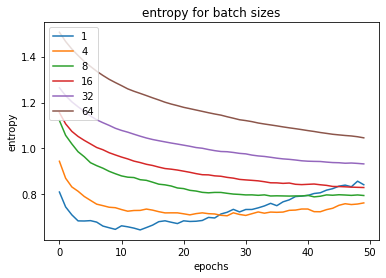

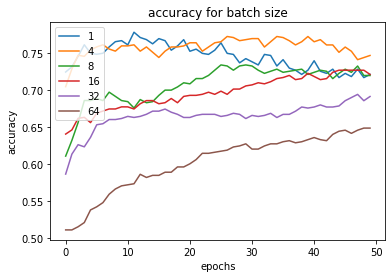

In [14]:
plt.figure(1)
for entropy in entropies:
    plt.plot(entropy)
plt.title('entropy for batch sizes')
plt.legend(batch_sizes, loc='upper left')
plt.ylabel('entropy')
plt.xlabel('epochs')

plt.figure(2)
for accuracy in accuracies:
    plt.plot(accuracy)
plt.title('accuracy for batch size')
plt.legend(batch_sizes, loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epochs')

In [15]:
med_times = pd.DataFrame(data={
    'batch_sizes': batch_sizes,
    'median_time': avg_times
})

med_times

,batch_sizes,median_time
0,1,0.000328
1,4,0.000365
2,8,0.000383
3,16,0.000400
4,32,0.000464
5,64,0.000570


##### Results
---
As we can see from the results above, a batch size of 8 seems to be the optimal for the problem above as it has a fractionally higher compute time than a batch size of 1. Its loss and accuracy has also plateaued at a moderate level without U-turning like that of batch sizes 1 and 4, or not being as accurate as batch size 64.


In [16]:
model = Sequential([
        Dense(16, activation='relu'),
        Dropout(rate=0.3),
        Dense(10, activation='softmax')
    ])
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
history = model.fit(X_train, y_train,
                   batch_size=16,
                   epochs=50,
                   verbose=0,
                   use_multiprocessing=True,
                   validation_data=(X_test, y_test))

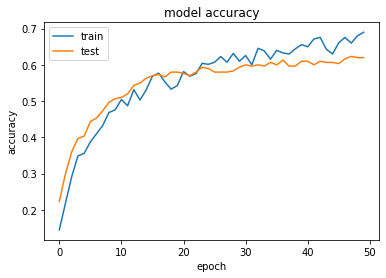

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Question 3
### Optimum hidden neurons

In [18]:
num_neurons = [8, 16, 32, 64]

def train_neurons(neurons):
    model = Sequential([
        Dense(neurons, activation='relu'),
        Dropout(rate=0.3),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
    
    splits = 3
    kf = KFold(n_splits=splits)
    
    accuracies=[]
    
    for train_index, test_index in kf.split(X_train):
        history = model.fit(X_train[train_index], y_train[train_index],
                           batch_size=16,
                           epochs=50,
                           verbose=0,
                           use_multiprocessing=False,
                           validation_data=(X_train[test_index], y_train[test_index]))
        
        accuracies.append(history.history['val_accuracy'])
        
    return np.mean(accuracies, axis=0)

In [19]:
accuracies=[]

for neurons in num_neurons:
    accuracies.append(train_neurons(neurons))

Text(0.5, 0, 'epochs')

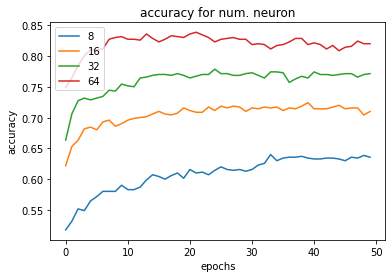

In [20]:
for accuracy in accuracies:
    plt.plot(accuracy)
plt.title('accuracy for num. neuron')
plt.legend(num_neurons, loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epochs')

##### Results
---
As we can see from the plot above, the optimum number of neurons in the hidden layer is 64 as it produces the highest cross validated, validation accuracy amongst all the possible number of neurons. In addition to the number of neurons, we can also tune the dropout rate, the number of neurons, as well as the $L_1$ and $L_2$ Normalisations.


In [21]:
model = Sequential([
        Dense(64, activation='relu'),
        Dropout(rate=0.3),
        Dense(10, activation='softmax')
    ])

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                   batch_size=16,
                   epochs=50,
                   verbose=0,
                   use_multiprocessing=True,
                   validation_data=(X_test, y_test))

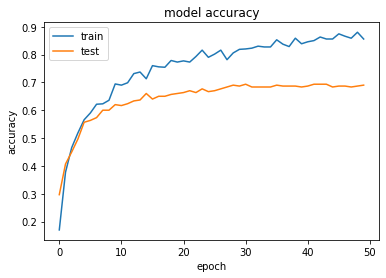

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Question 4
### 3-Layer Network

In [23]:
model = Sequential([
        Dense(64, activation='relu'),
        Dropout(rate=0.3),
        Dense(64, activation='relu'),
        Dropout(rate=0.3),
        Dense(10, activation='softmax')
    ])

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                   batch_size=1,
                   epochs=50,
                   verbose=0,
                   use_multiprocessing=True,
                   validation_data=(X_test, y_test))

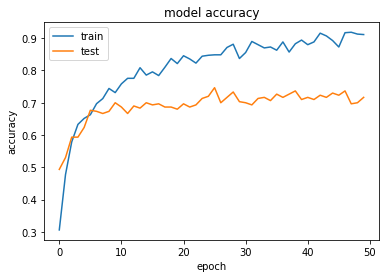

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### Result
---
The tuned model took longer to get to the same training and testing accuracy as the 3 layered model. However the change in accuracy for each epoch was smoother for the tuned model.

# Question 5
---
### Removing dropouts



In [25]:
model = Sequential([
        Dense(16, activation='relu'),
        Dense(10, activation='softmax')
    ])

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                   batch_size=1,
                   epochs=50,
                   verbose=0,
                   use_multiprocessing=True,
                   validation_data=(X_test, y_test))

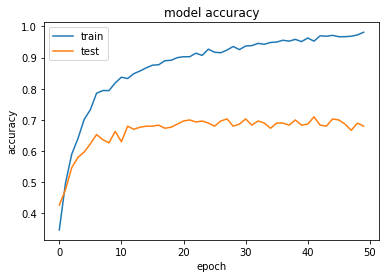

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

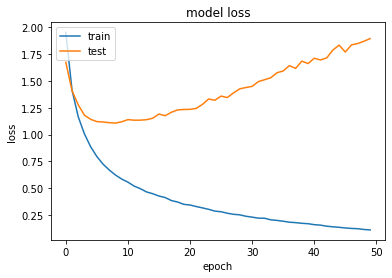

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### Result
---
As we can see from the above, dropouts prevent the model from overfitting to the training data by keeping the testing accuracy close to the training accuracy and it prevents the testing loss from increasing. Another approach to prevent overfitting would be to implement an early stop or to to have $L_1$ or $L_2$ normalisation.

# Conclusion
---
All the parameters that we have looked at thus far had some impact in how the model behaved once trained. The most impactful parameter in my opinion is the number of neurons in the hidden layer as the difference in the accuracy of the model was so much greater than that of the other parameters. 

An alternative approach to genre classification could be to have the neural network analyse the waveforms themselves. I would suggest that the inputs to the network could be the different frequencies that are in the waveform to seperate out the different instrument types that exist in the recording. For example drums are of a lower frequency and guitars of a higher. Then the network could learn how different "instruments" define the genre of the music from its "sound".

Additionally, there was no pre-processsing done to the data before it was fed to the model. Perhaps if the data was normalised in some form, the inputs would be within the same range and thus the model might learn to prioritise the important features more easily.
